In [28]:
import pandas as pd

# Load the dataset into a pandas dataframe
df = pd.read_csv('tracks.csv')

# Select a random sample of 20% of the data
df = df.sample(frac=0.2, random_state=42)


Popularity Statistics:

mean      27.562795
median    27.000000
25%       13.000000
75%       40.000000
std       18.292529
Name: popularity, dtype: float64


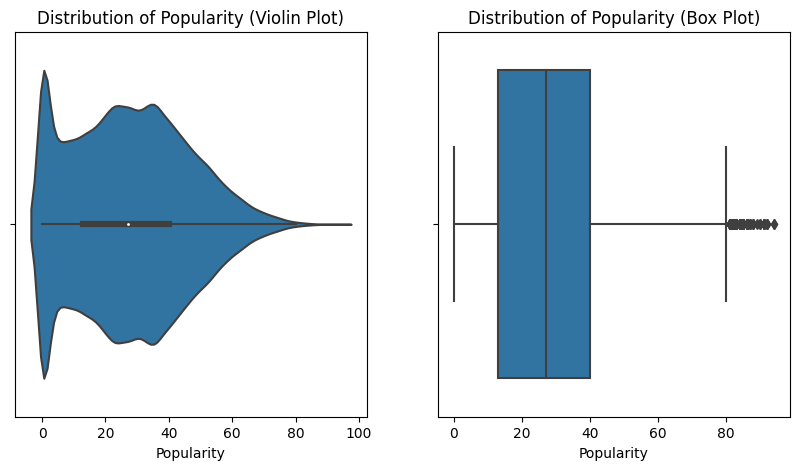

In [29]:
#First let us examine the distribution of popularity in the dataset
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate the mean, median, quartiles, and variance of popularity
popularity_stats = df['popularity'].describe()[['mean', '50%', '25%', '75%', 'std']]
popularity_stats.rename(index={'50%': 'median'}, inplace=True)

print('Popularity Statistics:\n')
print(popularity_stats)

# Create a violin plot and box plot of popularity
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.violinplot(x=df['popularity'], ax=axes[0])
axes[0].set_title('Distribution of Popularity (Violin Plot)')
axes[0].set_xlabel('Popularity')

sns.boxplot(x=df['popularity'], ax=axes[1])
axes[1].set_title('Distribution of Popularity (Box Plot)')
axes[1].set_xlabel('Popularity')

plt.show()

Based on this we cann see that on average a song's popularity is 27.56 and there is a high variance of 18.29. On the box plot, we can see a considerable number on anomolies. Moving forward, we will try to account for factors that contribute to such outliers.

## Duration and Popularity

Duration Statistics:

mean      230283 ms
median    214987 ms
25%       175213 ms
75%       264000 ms
std       126151 ms
Name: duration_ms, dtype: object


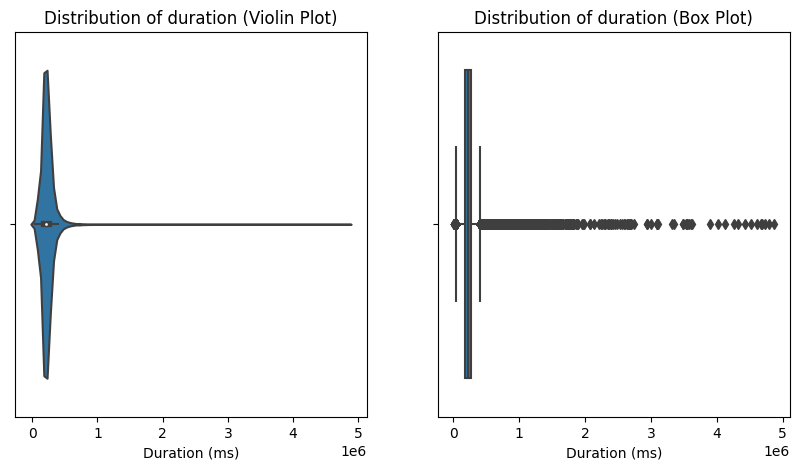

In [30]:
# Calculate the mean, median, quartiles, and variance of duration
duration_stats = df['duration_ms'].describe()[['mean', '50%', '25%', '75%', 'std']]
duration_stats.rename(index={'50%': 'median'}, inplace=True)
duration_stats = duration_stats.astype(int).astype(str) + ' ms'

print('Duration Statistics:\n')
print(duration_stats)

# Create a violin plot and box plot of duration
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.violinplot(x=df['duration_ms'], ax=axes[0])
axes[0].set_title('Distribution of duration (Violin Plot)')
axes[0].set_xlabel('Duration (ms)')

sns.boxplot(x=df['duration_ms'], ax=axes[1])
axes[1].set_title('Distribution of duration (Box Plot)')
axes[1].set_xlabel('Duration (ms)')

plt.show()

Based on this distirbution, we can see a high number of anomolies on one side as well. Next, let us see if this accounts for popularity in any case

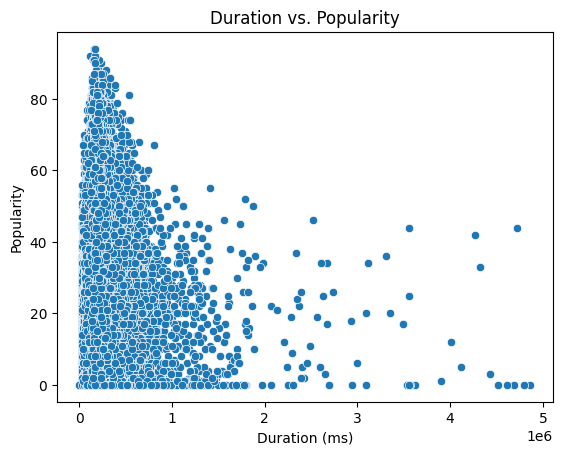

Correlation coefficient: 0.026198844435751677


In [31]:
#Next, let us see if there is a direct relationship between duration and popularity through a scatter plot

# Create a scatter plot of duration_ms vs. popularity
sns.scatterplot(x='duration_ms', y='popularity', data=df)

# Set the plot title and axis labels
plt.title('Duration vs. Popularity')
plt.xlabel('Duration (ms)')
plt.ylabel('Popularity')

# Show the plot
plt.show()


# Calculate the correlation coefficient between duration_ms and popularity
corr = df['duration_ms'].corr(df['popularity'])

# Print the correlation coefficient to the console
print('Correlation coefficient:', corr)

Based on this, we see that the correlation coefficient is extremely low and popularity does not seem to be related to duration at all. However, we notice that songs with popularity over 60 always have a relatively low duration. Let us now account for this using a new analysis method - Clusetering

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Duration Range by Cluster (in ms):
                min         max
cluster                        
0         345090 ms   744587 ms
1           4000 ms   208188 ms
2        2135307 ms  4864333 ms
3         746507 ms  2072133 ms
4         208193 ms   345067 ms


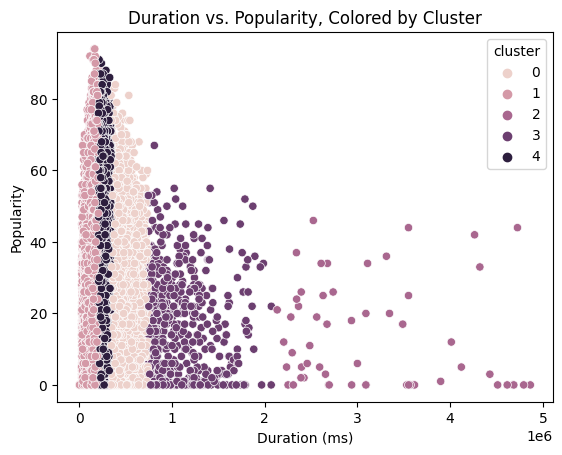

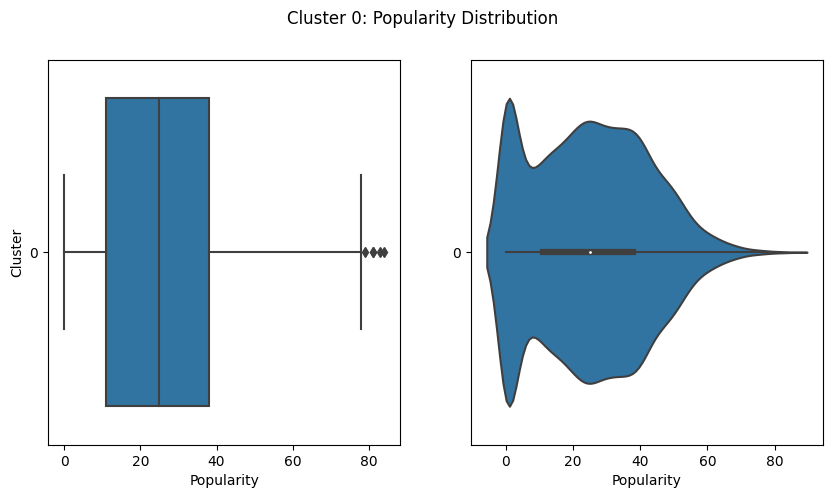

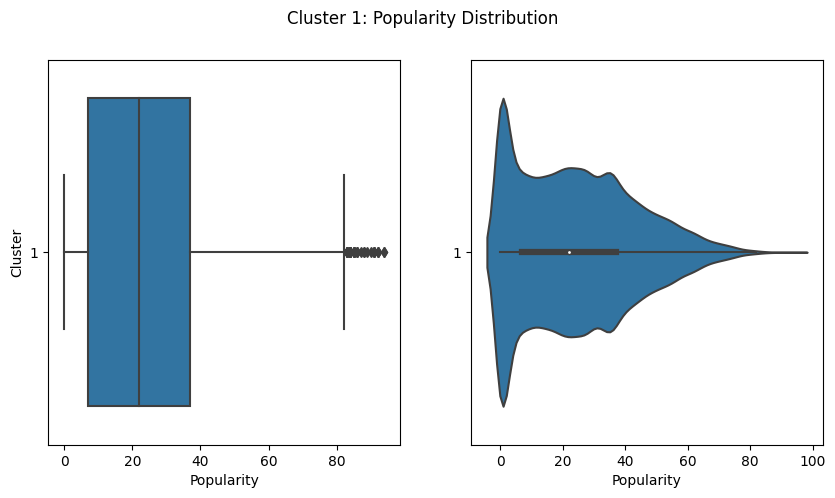

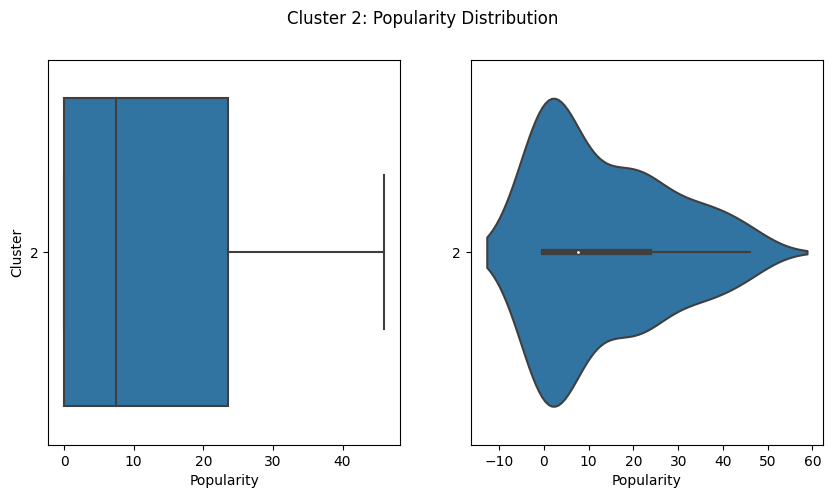

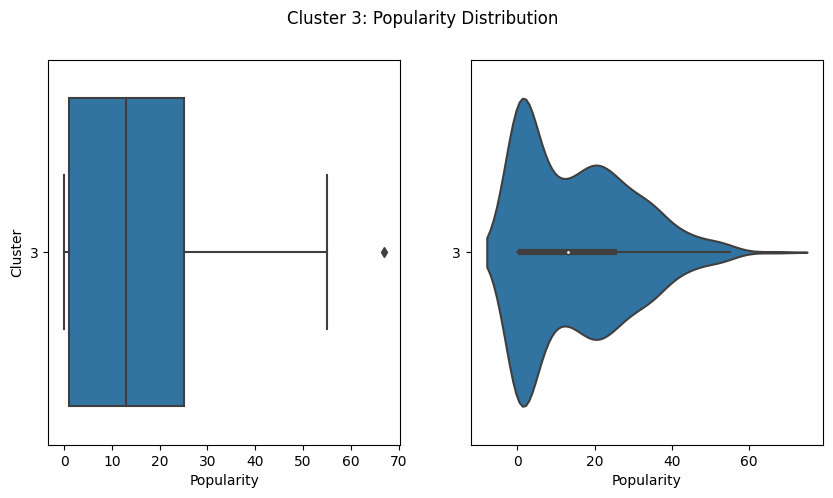

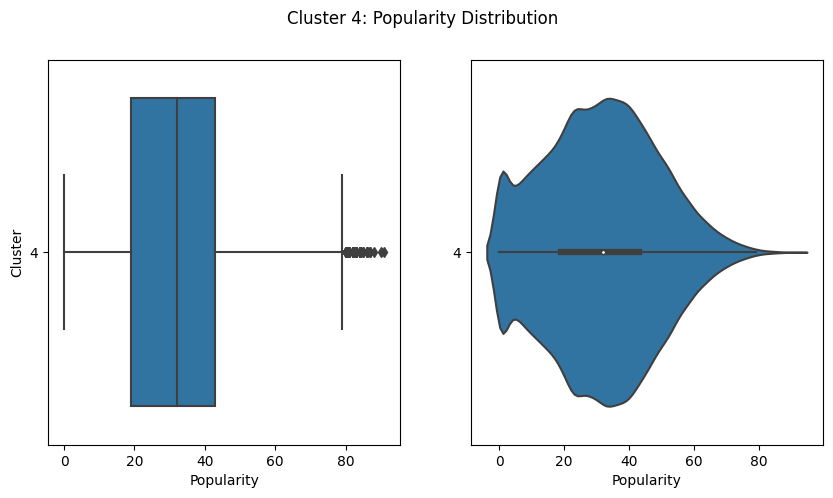

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Extract the duration and popularity features
X = df[['duration_ms', 'popularity']]

# Perform k-means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(X)

# Add the cluster labels to the dataframe
df['cluster'] = labels

# Group the DataFrame by cluster labels and calculate the duration range for each cluster
cluster_duration_range = df.groupby('cluster')['duration_ms'].agg(['min', 'max'])

# Add the unit "ms" to the duration range values
cluster_duration_range['min'] = cluster_duration_range['min'].apply(lambda x: str(x) + ' ms')
cluster_duration_range['max'] = cluster_duration_range['max'].apply(lambda x: str(x) + ' ms')

# Print the duration range for each cluster
print("Duration Range by Cluster (in ms):")
print(cluster_duration_range)

# Create a scatterplot of duration vs. popularity, colored by cluster
sns.scatterplot(data=df, x='duration_ms', y='popularity', hue='cluster')
plt.title('Duration vs. Popularity, Colored by Cluster')
plt.xlabel('Duration (ms)')
plt.ylabel('Popularity')
plt.show()

# Create boxplots and violin plots of popularity for each cluster
for i in range(5):
    cluster_data = df.loc[df['cluster'] == i]
    fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
    sns.boxplot(x='popularity', y='cluster', data=cluster_data, orient='horizontal', ax=axes[0])
    sns.violinplot(x='popularity', y='cluster', data=cluster_data, orient='horizontal', ax=axes[1])
    fig.suptitle(f"Cluster {i}: Popularity Distribution")
    axes[0].set_xlabel('Popularity')
    axes[1].set_xlabel('Popularity')
    axes[0].set_ylabel('Cluster')
    axes[1].set_ylabel('')
    plt.show()


Here, we see a significant difference in each of these cluseters which has to be proven to prove our hypothesis that one cluster is better than another when it comes to popularity. As our data is not normally distirbuted, we will use the Kruskal-Wallis test to determine if a cluster is better than the other. If the p-value of the Kruskal-Wallis test is less than the chosen significance level (e.g. 0.05), we can reject the null hypothesis and conclude that at least one of the groups has a different median than the others.

In [33]:
from scipy.stats import kruskal

# Calculate the median popularity for each cluster
cluster_medians = df.groupby('cluster')['popularity'].median()

# Perform Kruskal-Wallis test
stat, pval = kruskal(*[cluster_data['popularity'].values for _, cluster_data in df.groupby('cluster')])

# Print the median popularity for each cluster
print("Median Popularity by Cluster:")
print(cluster_medians)

# Print the Kruskal-Wallis test results
print("Kruskal-Wallis Test Results:")
print("Test statistic:", stat)
print("p-value:", pval)

Median Popularity by Cluster:
cluster
0    25.0
1    22.0
2     7.5
3    13.0
4    32.0
Name: popularity, dtype: float64
Kruskal-Wallis Test Results:
Test statistic: 5341.504657092034
p-value: 0.0


## A p value of 0.0 suggest a strong evidence against the null hypothesis, and suggests that a cluster does indeed have better popularity than another. As such, we can conclude that clusters do affect popularity. Based on the test, we see that cluster 4 has the highest median with a significant difference. As such, we suggests aspiring top aritists to have songs with duration in cluster 4. Cluster 4 = 208.2 seconds - 345.1 seconds (3mins 28 seconds - 5 mins 45 seconds)

## Explicit and Popularity (1 and 0)

In [34]:
data = pd.read_csv('tracks.csv')
subset = data[['explicit', 'popularity']]


In [35]:
import matplotlib.pyplot as plt

explicit = df[df['explicit'] == 1]['popularity']
non_explicit = df[df['explicit'] == 0]['popularity']

print(f"Number of data points in Explicit group: {len(explicit)}")
print(f"Number of data points in Non-Explicit group: {len(non_explicit)}")



Number of data points in Explicit group: 5076
Number of data points in Non-Explicit group: 112258


As the number of data points for explicit is significantly lesser, we will balance the sample sizes by randomly sampling the non-explicit songs group to match the number of data points in the explicit songs group.

In [36]:
non_explicit_sample = non_explicit.sample(n=5076, random_state=42)
print(f"Number of data points in Explicit group: {len(explicit)}")
print(f"Number of data points in Non-Explicit group: {len(non_explicit_sample)}")

Number of data points in Explicit group: 5076
Number of data points in Non-Explicit group: 5076


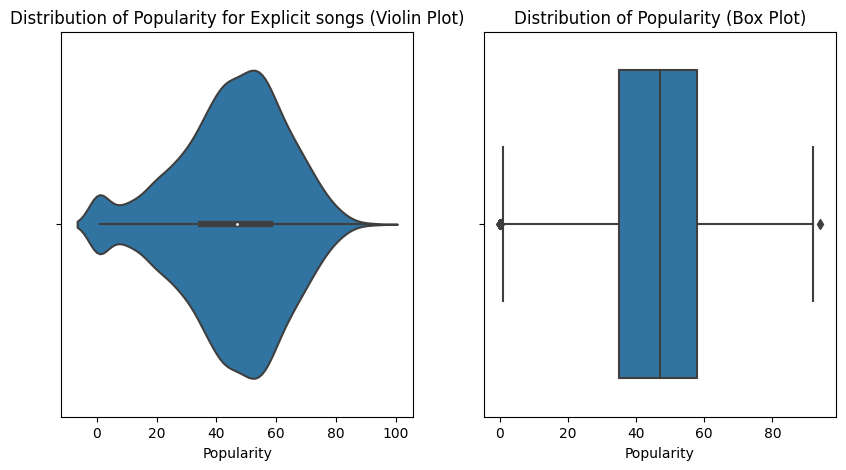

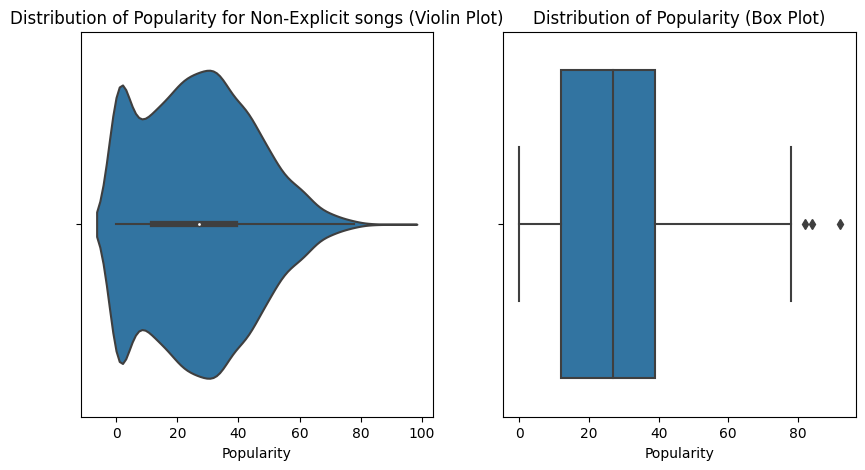

Popularity Statistics (Explicit):

mean      45.295902
median    47.000000
25%       35.000000
75%       58.000000
std       18.059123
Name: popularity, dtype: float64
Popularity Statistics (Non-Explicit):

mean      26.709417
median    27.000000
25%       12.000000
75%       39.000000
std       17.729563
Name: popularity, dtype: float64


In [37]:
# Create a violin plot and box plot of popularity
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.violinplot(x=explicit, ax=axes[0])
axes[0].set_title('Distribution of Popularity for Explicit songs (Violin Plot)')
axes[0].set_xlabel('Popularity')

sns.boxplot(x=explicit, ax=axes[1])
axes[1].set_title('Distribution of Popularity (Box Plot)')
axes[1].set_xlabel('Popularity')


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.violinplot(x=non_explicit_sample, ax=axes[0])
axes[0].set_title('Distribution of Popularity for Non-Explicit songs (Violin Plot)')
axes[0].set_xlabel('Popularity')

sns.boxplot(x=non_explicit_sample, ax=axes[1])
axes[1].set_title('Distribution of Popularity (Box Plot)')
axes[1].set_xlabel('Popularity')


plt.show()

# Calculate the mean, median, quartiles, and variance of popularity
popularity_stats = explicit.describe()[['mean', '50%', '25%', '75%', 'std']]
popularity_stats.rename(index={'50%': 'median'}, inplace=True)

print('Popularity Statistics (Explicit):\n')
print(popularity_stats)



# Calculate the mean, median, quartiles, and variance of popularity
popularity_stats = non_explicit_sample.describe()[['mean', '50%', '25%', '75%', 'std']]
popularity_stats.rename(index={'50%': 'median'}, inplace=True)

print('Popularity Statistics (Non-Explicit):\n')
print(popularity_stats)

Looking at above, we can hypothesize that explicit songs tend to do better thanks to their high mean and median. Next, we will perform a statistical test to compare the two groups. We will be using a two-sample t-test, which can determine if the difference in means between two groups is statistically significant.

In [44]:
import scipy.stats as stats

# Conduct two-sample t-test
t, p = stats.ttest_ind(explicit, non_explicit_sample)

# Print t-test results
print('Two-Sample t-Test Results:')
print(f"t = {t:.3f}")
print(f"p = {p:.3f}")

# Determine if difference in means is significant
if p < 0.05:
    print("The difference in means is statistically significant.")
else:
    print("The difference in means is not statistically significant.")


Two-Sample t-Test Results:
t = 52.325
p = 0.000
The difference in means is statistically significant.


A very small p-value indicates that the difference in means is even less likely to be due to chance and provides strong evidence for the alternative hypothesis that there is a true difference between the two groups. It's important to note that while a significant result would suggest that explicit songs tend to have higher popularity than non-explicit songs, it does not necessarily prove causation. There may still be other confounding factors that are influencing the difference in means.